In [2]:
#!pip uninstall huetracer -y
#!pip install huetracer
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns
import os
import random
import numpy as np
import pandas as pd
import scvi
import gc
import math
import bin2cell as b2c
import torch
from itertools import cycle
from sklearn.neighbors import NearestNeighbors
import importlib
import gdown
import zipfile
import adjustText as at
import scipy
import huetracer
import plotly.graph_objects as go
importlib.reload(huetracer)

pd.set_option('display.max_columns', None)
sc.set_figure_params(figsize=[10,10],dpi=100)

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

scvi.settings.seed = 0
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else"mps" if torch.backends.mps.is_available() else "cpu")
device_str = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")

Seed set to 0


Using device: mps


In [3]:
### parameters to be input
SAMPLE_NAME = 'G1'
lib_id = SAMPLE_NAME # list(sp_adata.uns['spatial'].keys())[0]

path = os.path.expanduser("~")+"/Desktop/space/GCTB_bin2cell"
save_path_for_today = os.path.expanduser("~")+"/tmp/outputs/250610_" + SAMPLE_NAME
source_image_path = "../VisiumHD/image/microscope_image/" + SAMPLE_NAME + ".tif"

### ligand-receptor data obtained from nichenet, download only once
# # 1. Google Drive link URL
# url = "https://drive.google.com/uc?export=download&id=1pMpGUfsrDNWmZ_osfSglX5MrL8e8vOeA"
# # 2. File name
# output = "ligand_target_df.csv.zip"
# # 3. Download
# gdown.download(url, output, quiet=False)
# # 4. ZIP file extraction
# with zipfile.ZipFile(output, 'r') as zip_ref:
#     zip_ref.extractall("ligand_target_df")

# 5. Set your path
file_nichenet = '../GCTB_bin2cell/data/tutorial/ligand_target_df.csv'

# area to be analyzed
# ## GCTB spatial G1, FFPE9
mask_large_x1, mask_large_x2, mask_large_y1, mask_large_y2 = 450, 1950, 250, 1750

# List of target gene names
target_genes = [
    'TNFSF11', 'LIF', 'TNFRSF11A', 'LIFR',
    'CTSK', 'CTSB', 'LMNB1', 'MEGF10',
    'MMP9', 'MMP13', 'SPP1', 'GRN',
    'NOTCH3', 'SDC2', 'TIMP1', 'SPARC',
    'ACP5'
    # Add more genes here if needed
]

annotation_dict = {
    'C0':  'Tumor',
    'C1':  'Tumor',
    'C2':  'Tumor',
    'C3':  'Monocyte',
    'C4':  'Tumor',
    'C5':  'Lymphocyte',
    'C6':  'Endothelial',
    'C7':  'Monocyte',
    'C8':  'CAFibroblast',
    'C9':  'GiantCell',
    'C10': 'GC_proliferating',
    'C11': 'GiantCell',
    'C12': 'Tumor',
    'C13': 'Tumor',
    'C14': 'Doublet',
    'C15': 'Doublet',
    'C16': 'Tumor',
    'C17': 'Monocyte',
    'C18': 'Doublet',
    'C19': 'Tumor',
    'C20': 'Monocyte',
    'C21': 'Tumor',
    'C22': 'Tumor'
}

target_cell_type = annotation_dict['C0'] # Simply select a single cell type as cluster number
# target_cell_type = 'Airway epithelial cells (CAPN8+, ELF3+)' # 'Tumor', 'GiantCell', etc., replace with your desired CellType

Gene_to_analyze = "LIF"
# Gene_to_analyze = "CSF1"

# Definition of neighborhood cells
neighbor_cell_numbers = 19

#role = 'sender'
role = 'receiver'
each_display_num = 3

# Volcano plot of gene expression between clusters
group1_environments = ['0', '2'] # Microenvironmentのカテゴリ名。文字列で定義
group2_environments = ['1', '3'] # Microenvironmentのカテゴリ名。文字列で定義

# setting for filenames
label_image_filename = "he_labels_image.pdf"
h5ad_filename = SAMPLE_NAME + "_b2c.h5ad"
h5ad_full_filename = SAMPLE_NAME + "_2um.h5ad"
h5ad_predicted_full_filename = SAMPLE_NAME + "_nucleus_predicted.h5ad"
h5ad_sc_filtered_full_filename = SAMPLE_NAME + "_single_cell_filtered.h5ad"
h5ad_sc_microenvironment_full_filename = SAMPLE_NAME + "_single_cell_microenvironment.h5ad"
save_spatial_plot_path = os.path.join(save_path_for_today, "cropped_spatial_plot.svg")
save_svg_path = os.path.join(save_path_for_today, "spatial_salvage_labels.svg")
h5ad_save_path = os.path.join(save_path_for_today, h5ad_filename)
h5ad_full_save_path = os.path.join(save_path_for_today, h5ad_full_filename)
h5ad_predicted_full_save_path = os.path.join(save_path_for_today, h5ad_predicted_full_filename)
h5ad_sc_filtered_full_save_path = os.path.join(save_path_for_today, h5ad_sc_filtered_full_filename)
h5ad_microenvironment_full_save_path = os.path.join(save_path_for_today, h5ad_sc_microenvironment_full_filename)

os.chdir(path)
os.makedirs(save_path_for_today, exist_ok=True)


/Users/ikegami/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/ikegami/.pyenv/versions/3.11.7/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



Microenvironment data construction...


100%|██████████████████████████████████████████████████████████████████████████████████████| 50445/50445 [00:04<00:00, 11739.60it/s]
/Users/ikegami/.pyenv/versions/3.11.7/lib/python3.11/site-packages/huetracer/cci.py:203: ImplicitModificationWarning:

Setting element `.layers['expr_up']` of view, initializing view as actual.

/var/folders/4d/y2tgzy191n37wnz840jkr6980000gp/T/ipykernel_42909/137019821.py:48: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/var/folders/4d/y2tgzy191n37wnz840jkr6980000gp/T/ipykernel_42909/137019821.py:49: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/4d/y2tgzy191n37wnz840jkr6980000gp/T/ipykernel_42909/137019821.py:51: FutureWarning:

Use `squidpy.pl.spatial_scatter` instead.



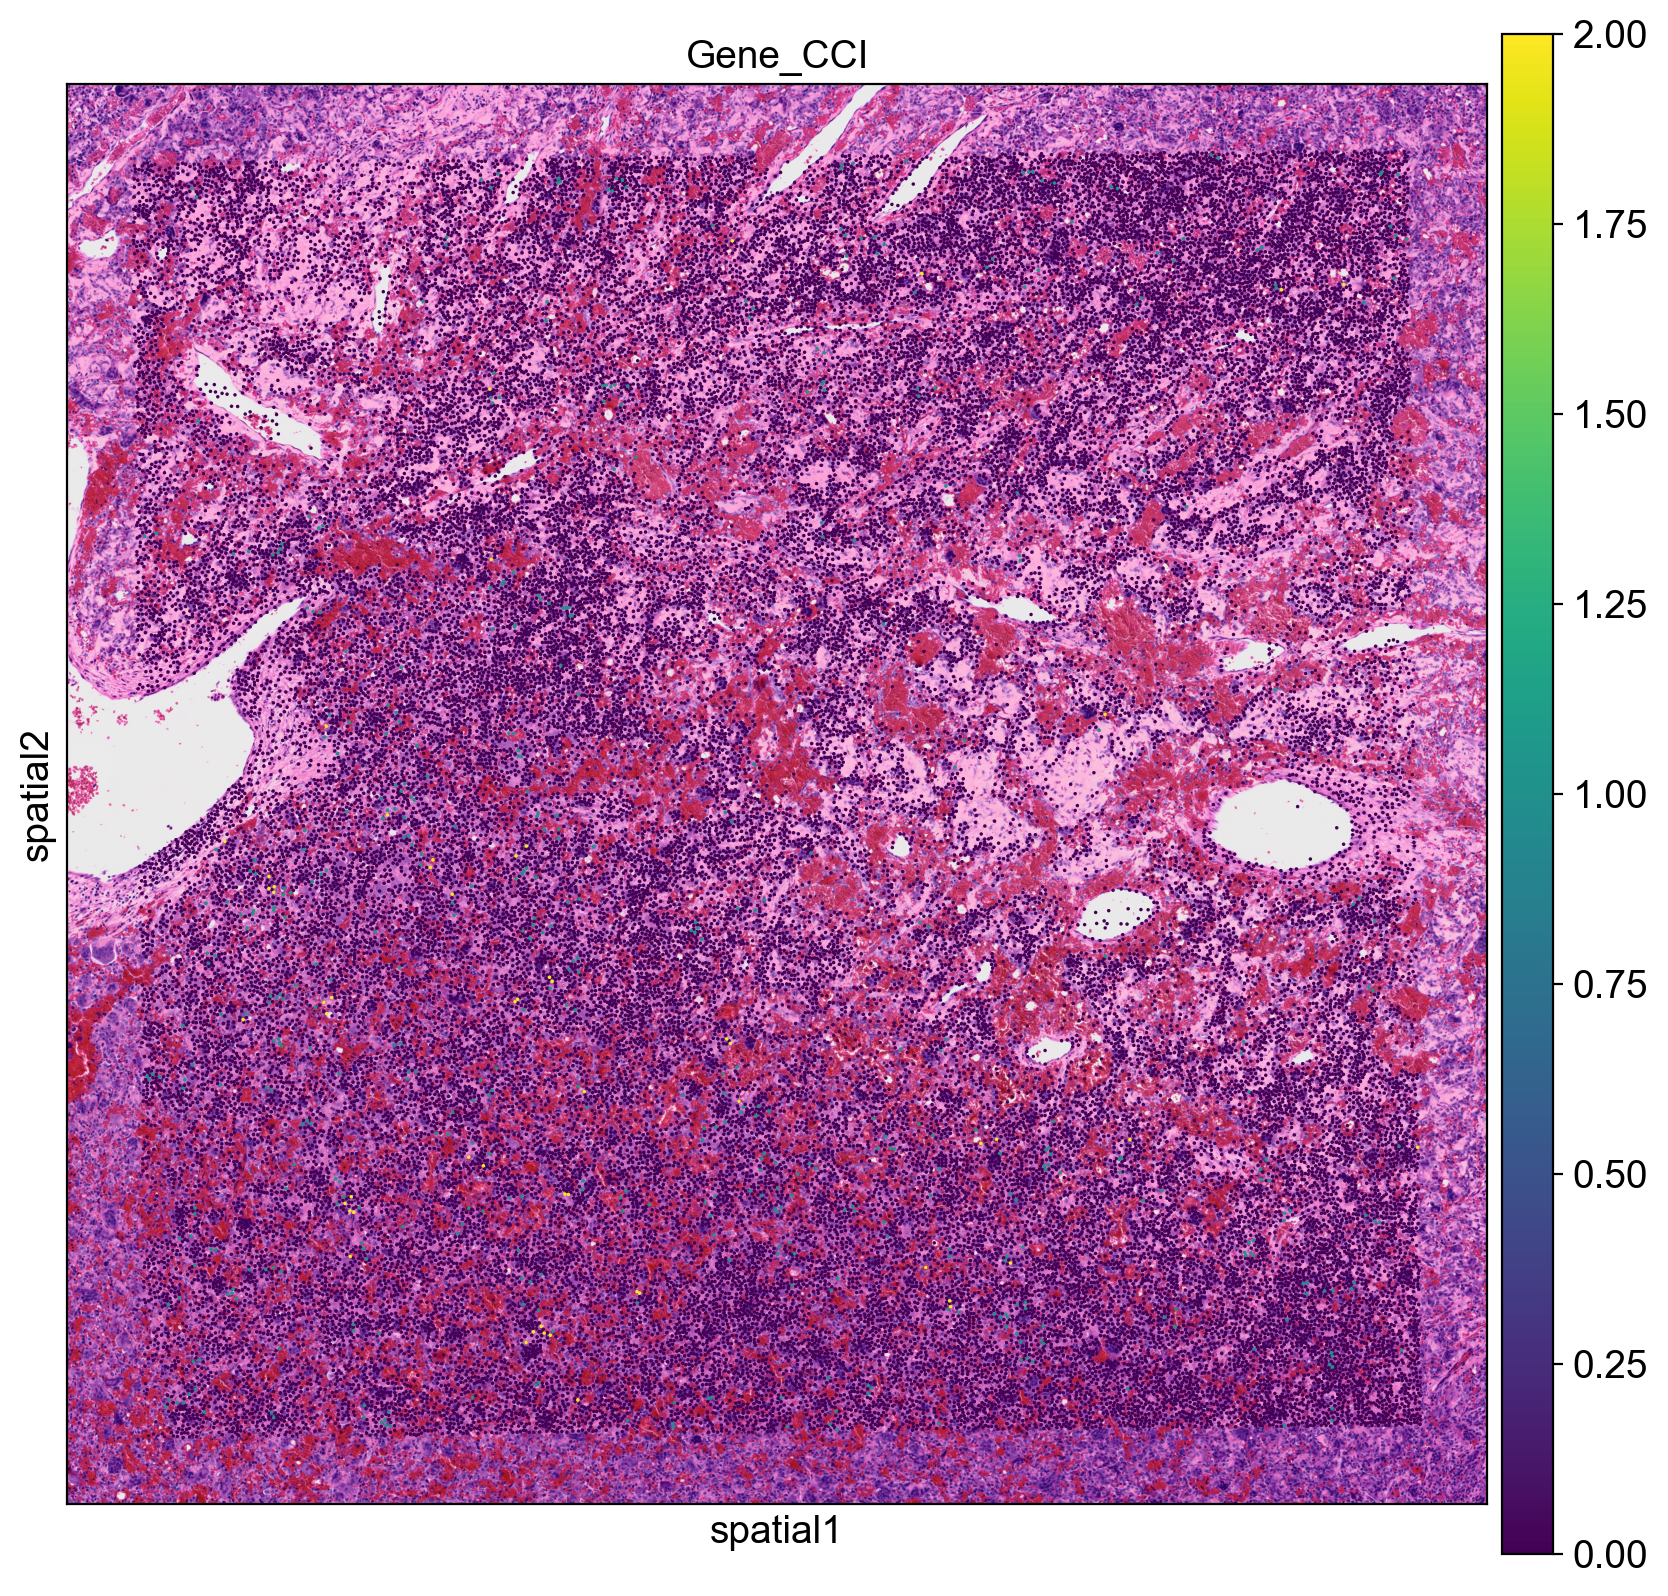

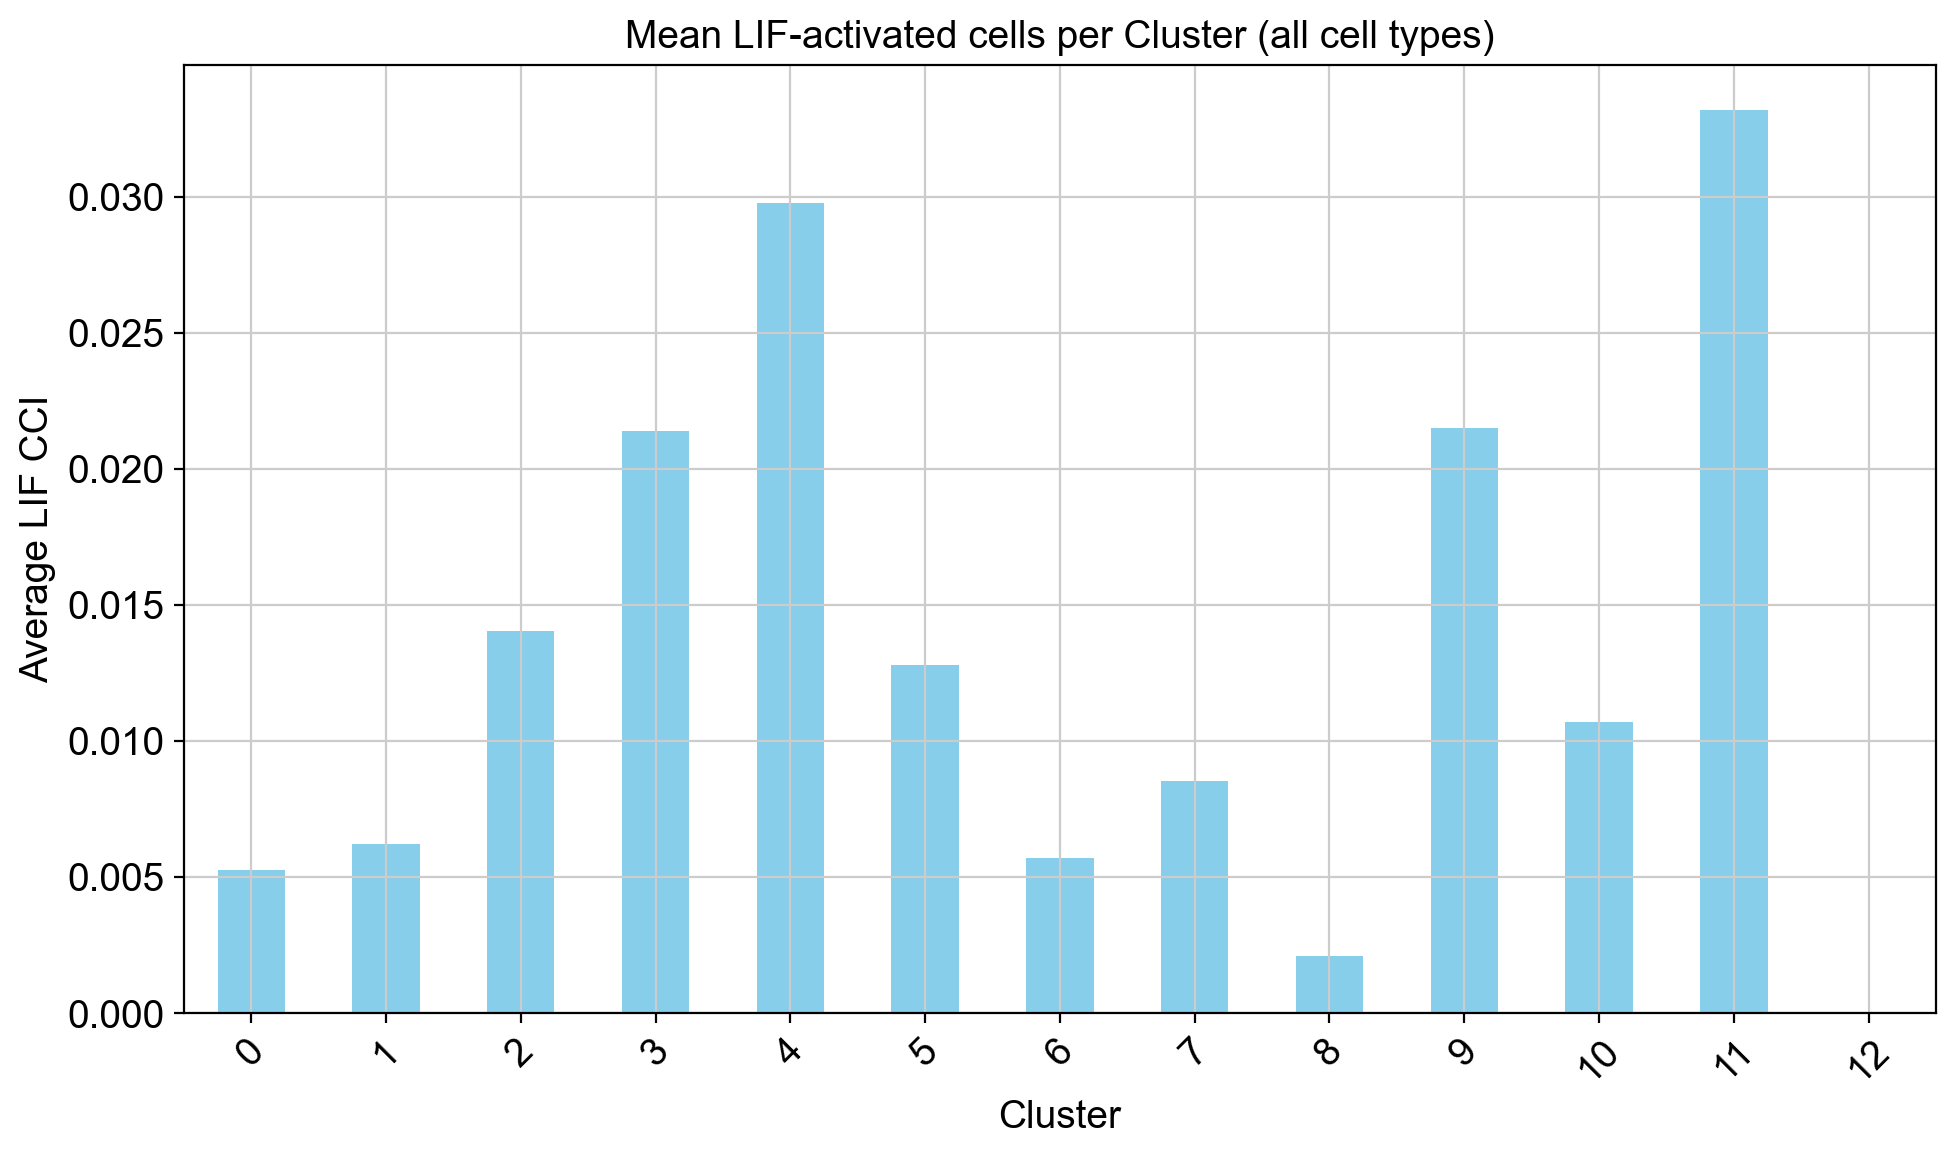

/var/folders/4d/y2tgzy191n37wnz840jkr6980000gp/T/ipykernel_42909/137019821.py:84: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



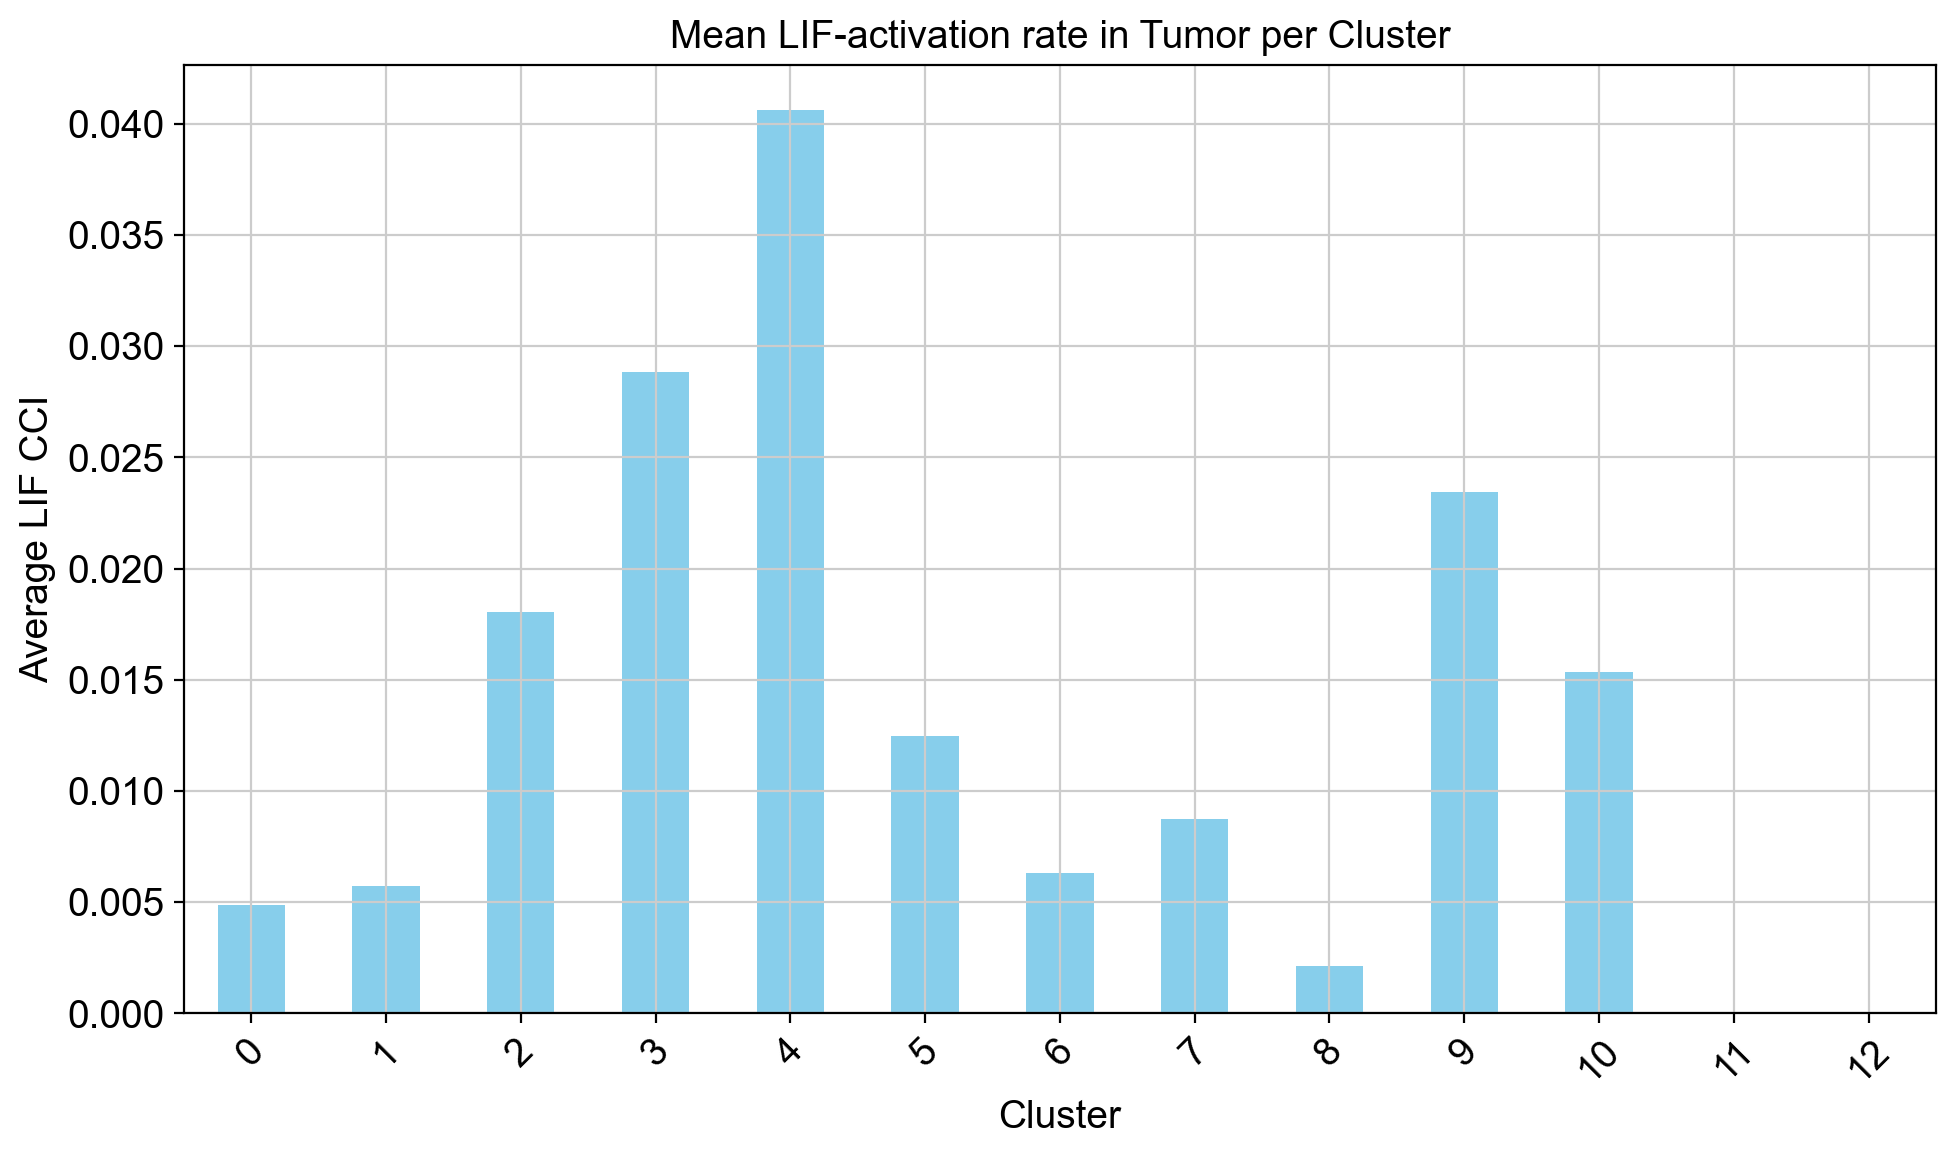

/var/folders/4d/y2tgzy191n37wnz840jkr6980000gp/T/ipykernel_42909/137019821.py:148: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



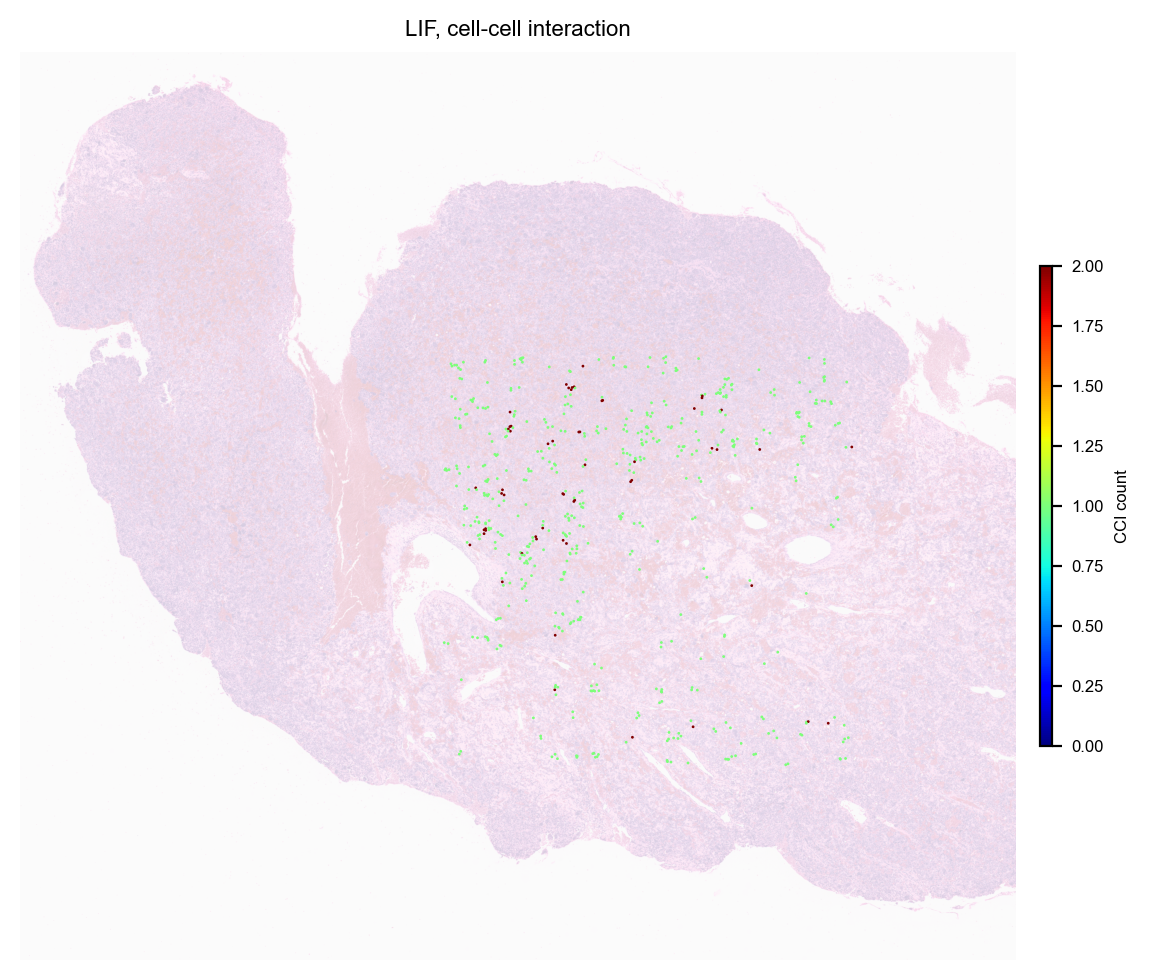

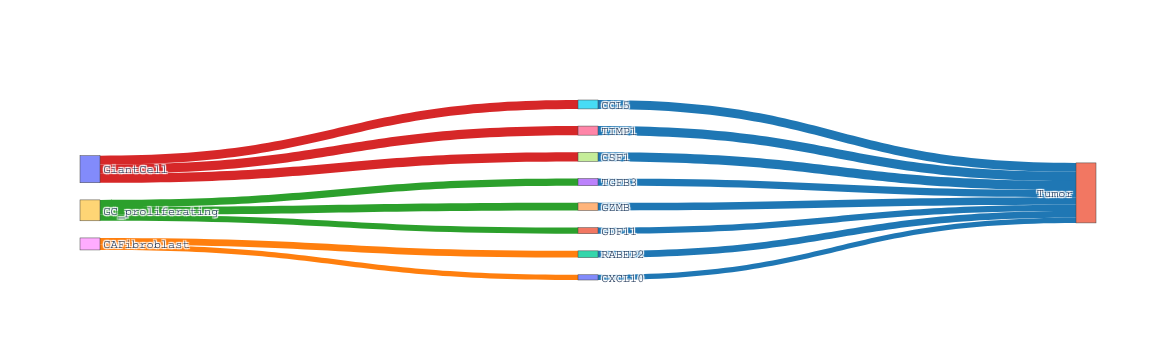

In [82]:
# DeepCOLOR-like analysis with NicheNet database

sp_adata_raw = sc.read_h5ad(h5ad_save_path)
sp_adata_microenvironment = sc.read_h5ad(h5ad_microenvironment_full_save_path)
lt_df_raw = pd.read_csv(file_nichenet, index_col=0)

### choose microenvironment clusters to be analyzed
cluster_label = np.unique(sp_adata_microenvironment.obs['predicted_microenvironment'])
#cluster_label = ['0', '1', '2']

sp_adata, lt_df = huetracer.prepare_microenv_data(sp_adata_raw, sp_adata_microenvironment, lt_df_raw)

# 新しいレイヤーを作成して元のデータを保持
# sp_adata.X の形状を取得
sp_adata = sp_adata.copy()
if scipy.sparse.issparse(sp_adata.X):
    sp_adata.X = sp_adata.X.toarray()
huetracer.add_zscore_layers(sp_adata)

mask = sp_adata.obs['cluster'].isin(cluster_label)
cluster_cells = sp_adata[mask]

top_diff_expr_genes = huetracer.make_top_values(cluster_cells.layers["zscore_by_celltype"], axis=1, top_fraction=0.01)
expr_up_by_ligands = huetracer.make_top_values(top_diff_expr_genes @ lt_df, axis=0, top_fraction=0.1).to_numpy()
ligands = lt_df.columns

edge_df, center_adata, exp_data = huetracer.construct_microenvironment_data(
    sp_adata=sp_adata,
    cluster_cells=cluster_cells,
    ligands=ligands,
    expr_up_by_ligands=expr_up_by_ligands,
    neighbor_cell_numbers=neighbor_cell_numbers
)

# 平均よりも1.5倍CCIが生じているligandを抽出
coexp_cc_df, bargraph_df = huetracer.calculate_coexpression_coactivity(edge_df, center_adata, exp_data, expr_up_by_ligands, role=role, up_rate = 1.5)

# save CCI data as an excel file
filename = SAMPLE_NAME + "_environment_to_center_df_cell_type_cell_1_is_" + role + ".xlsx"
out_xlsx = os.path.join(save_path_for_today, filename)
coexp_cc_df.to_excel(out_xlsx)

# クラスタごとの Gene_CCI の平均を計算
bargraph_df["cell1"] = edge_df["cell1"].values
gene_counts = bargraph_df.groupby("cell1")[Gene_to_analyze].sum()
result_series = pd.Series(0, index=cluster_cells.obs_names, dtype=int)
result_series.loc[gene_counts.index] = gene_counts.astype(int)
cluster_cells.obs['Gene_CCI'] = result_series
mean_gene_cci = cluster_cells.obs.groupby('cluster')['Gene_CCI'].mean()

sc.pl.spatial(cluster_cells,title=Gene_to_analyze + '-activated cells', color="Gene_CCI", spot_size=30)

# 棒グラフを描画
plt.figure(figsize=(10, 6))
mean_gene_cci.plot(kind='bar', color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Average ' + Gene_to_analyze + ' CCI')
plt.title('Mean ' + Gene_to_analyze + '-activated cells per Cluster (all cell types)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 行をフィルタして、対象中心細胞種のみ抽出
giant_mask = cluster_cells.obs["celltype"] == target_cell_type
giant_indices = giant_mask[giant_mask].index
filtered_df = bargraph_df[
    bargraph_df['cell1_type'] == target_cell_type
]
gene_counts = filtered_df.groupby("cell1")[Gene_to_analyze].sum()
result_series = pd.Series(0, index=giant_indices, dtype=int)
result_series.loc[gene_counts.index] = gene_counts.astype(int)

# 該当行数が一致するか確認
assert giant_mask.sum() == result_series.shape[0], "行数が一致しません！"

# 対応する細胞のみに値を代入
cluster_cells.obs.loc[giant_mask, 'Gene_CCI'] = result_series

# 新しい AnnData を作成（対象細胞だけ）
target_adata = cluster_cells[giant_mask].copy()

# --- クラスタごとの平均計算 ---
# 各クラスタごとの Gene_CCI 合計
sum_gene_cci = target_adata.obs.groupby('cluster')['Gene_CCI'].sum()
# 各クラスタの細胞数
cluster_counts = target_adata.obs['cluster'].value_counts().sort_index()
# クラスタごとの細胞1つあたりの CCI 平均値（除算）
mean_gene_cci_per_cell = sum_gene_cci / cluster_counts

# 棒グラフを描画
plt.figure(figsize=(10, 6))
mean_gene_cci_per_cell.plot(kind='bar', color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Average ' + Gene_to_analyze + ' CCI')
plt.title('Mean ' + Gene_to_analyze + '-activation rate in ' + target_cell_type + ' per Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 描画
hires_img = cluster_cells.uns["spatial"][lib_id]["images"]["hires"]
h, w = hires_img.shape[:2]

scale = cluster_cells.uns["spatial"][lib_id]["scalefactors"]["tissue_hires_scalef"]
coords = cluster_cells.obsm["spatial_cropped_150_buffer"]  # ← basisに対応

# Gene_CCIの値を取得
gene_cci_values = cluster_cells.obs["Gene_CCI"]

# 図の準備
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.add_axes([0, 0, 1, 1])

# 表示範囲の設定
x_start, x_end = 0, w       # 横方向
y_start, y_end = 0, h       # 縦方向

# 表示
ax.imshow(hires_img, extent=[0, w, h, 0], alpha=0.2)  # Y軸反転
ax.set_xlim(x_start, x_end)
ax.set_ylim(y_start, y_end)
ax.axis('off')  # 軸目盛りを消す

alphas = gene_cci_values.copy()
alphas[gene_cci_values == 0] = 0  # 値が0のとき完全に透明
alphas[gene_cci_values != 0] = 1  # 値が0のとき完全に透明

scaling = cluster_cells.uns["spatial"][lib_id]["scalefactors"]["tissue_hires_scalef"]
coords[:, 0] = cluster_cells.obsm["spatial"][:, 0] * scaling #+ x_end
coords[:, 1] = cluster_cells.obsm["spatial"][:, 1] * scaling #+ y_end

# 値ごとに色の濃さを変えてプロット（0は透明に）
scatter = ax.scatter(
    coords[:, 0],
    coords[:, 1],
    c=gene_cci_values,
    cmap='jet',
    s=1,
    alpha=alphas,  # 0のとき透明
    edgecolors='none'
)

ax.set_title(Gene_to_analyze + ', cell-cell interaction', fontsize=8)
cb = fig.colorbar(scatter, ax=ax, shrink=0.4, aspect=40, pad=0.02)
cb.set_label("CCI count", fontsize=6)
cb.ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()

sub_coexp_cc_df = coexp_cc_df.query(f"cell1_type == '{target_cell_type}'")
sub_coexp_cc_df = sub_coexp_cc_df[sub_coexp_cc_df.is_significant]
sub_coexp_cc_df = sub_coexp_cc_df.sort_values('coactivity_per_sender_cell_expr_ligand', ascending=False).groupby('cell2_type', as_index=False).head(n=each_display_num)
# plotting configurrations
cell1types = np.unique(sub_coexp_cc_df.loc[:,"cell1_type"])
cell2types = np.unique(sub_coexp_cc_df.loc[:,"cell2_type"])
target_color_dict=None
tot_list = (list(sub_coexp_cc_df.ligand.unique()) + 
            list(cell2types) + 
            list(cell1types))
ligand_pos_dict = pd.Series({
    ligand: i
    for i, ligand in enumerate(sub_coexp_cc_df.ligand.unique())
})
celltype_pos_dict = pd.Series({
    celltype: i + sub_coexp_cc_df.ligand.unique().shape[0]
    for i, celltype in enumerate(cell2types)
})
receiver_dict = pd.Series({
    celltype: i + sub_coexp_cc_df.ligand.unique().shape[0] + len(cell2types)
    for i, celltype in enumerate(cell1types)
})
senders = sub_coexp_cc_df.cell1_type.values if role == "sender" else sub_coexp_cc_df.cell2_type.values
receivers = sub_coexp_cc_df.cell2_type.values if role == "sender" else sub_coexp_cc_df.cell1_type.values
sources = pd.concat([ligand_pos_dict.loc[sub_coexp_cc_df.ligand.values], celltype_pos_dict.loc[senders]])
targets = pd.concat([receiver_dict.loc[receivers], ligand_pos_dict.loc[sub_coexp_cc_df.ligand.values]])
values = pd.concat([sub_coexp_cc_df['coactivity_per_sender_cell_expr_ligand'], sub_coexp_cc_df['coactivity_per_sender_cell_expr_ligand']])
labels = pd.concat([sub_coexp_cc_df['cell1_type'], sub_coexp_cc_df['cell2_type']])
unique_labels = labels.unique()
palette = sns.color_palette("tab10", n_colors=len(unique_labels)).as_hex()
target_color_dict = dict(zip(unique_labels, palette))
colors = pd.Series(target_color_dict)[labels]
fig = go.Figure(data=[go.Sankey(node=dict(label=tot_list),
    link=dict(
        source=sources,
        target=targets,
        value=-np.log10(values),
        color=colors,
        label=labels))])
fig.update_layout(font_family="Courier New")